In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import sys

# load data back 

In [2]:
pickle_file = 'train64.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (7200, 64, 64, 3) (7200,)
Validation set (3, 64, 64, 3) (3,)
Test set (3000, 64, 64, 3) (3000,)


In [3]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]  
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
image_size = 64
num_labels = 3
num_channels = 3 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (7200, 64, 64, 3) (7200, 3)
Validation set (3, 64, 64, 3) (3, 3)
Test set (3000, 64, 64, 3) (3000, 3)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [16]:
image_size = 64
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
pixel_depth =255.0
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
testing=np.ndarray(shape=(1,image_size, image_size,3),
                         dtype=np.float32)
testing[:,:] = (ndimage.imread('test3.jpg',mode='RGB').astype(float) - 
                    pixel_depth / 2) / pixel_depth
print (testing.shape)

(1, 64, 64, 3)


## note : this part  just work around testing model since   I can't figure out how tensorflow serving .

[ 1.  0.  0.]


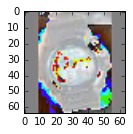

In [18]:
gogo=1
a=train_dataset[gogo , : , : , :] 
print (train_labels[0])
fig = plt.figure()
ax = fig.add_subplot(221)
ax.imshow(testing[0,:,:,:])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [10]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  tf_try = tf.constant(testing)
#   tf.app.flags.DEFINE_integer('training_iteration', 1000,
#                             'number of training iterations.')
#   tf.app.flags.DEFINE_integer('export_version', 1, 'version number of the model.')
#   tf.app.flags.DEFINE_string('work_dir', '/tmp', 'Working directory.')
#   FLAGS = tf.app.flags.FLAGS
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))  
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME',use_cudnn_on_gpu=True)    
    hidden = tf.nn.relu(conv + layer1_biases)
    hidden = tf.nn.dropout(tf.nn.max_pool(hidden , [1,2,2,1],[1,2,2,1],padding='SAME'),keep_prob =0.8)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME',use_cudnn_on_gpu=True)    
    hidden = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.dropout(tf.nn.max_pool(hidden , [1,2,2,1],[1,2,2,1],padding='SAME'),keep_prob = 0.8)
    
    shape = hidden.get_shape().as_list()    
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    print (reshape)
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  tf_p = tf.nn.softmax(model(tf_try))

Tensor("Reshape:0", shape=(16, 4096), dtype=float32)
Tensor("Reshape_1:0", shape=(3, 4096), dtype=float32)
Tensor("Reshape_2:0", shape=(3000, 4096), dtype=float32)
Tensor("Reshape_3:0", shape=(1, 4096), dtype=float32)


In [19]:
num_steps = 5001
from tensorflow.contrib.session_bundle import exporter

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  print(tf_p.eval(session=session))
  class_tensor = tf.constant(['Casio','Citizen','Seiko'])
    #classes = tf.contrib.lookup.index_to_string(tf.to_int64(indices),mapping=class_tensor)
    
    # check point : this part of code can export model and wait for reuse , and should just run it once .     
#   export_path = '/home/tensor/model'
#   print ('Exporting trained model to', export_path)
#   saver = tf.train.Saver(sharded=True)
#   model_exporter = exporter.Exporter(saver)
#   signature = exporter.classification_signature(input_tensor=tf_train_dataset, scores_tensor=train_prediction ,classes_tensor=class_tensor)
#   model_exporter.init(session.graph.as_graph_def(),
#                           default_graph_signature=signature)
#   model_exporter.export(export_path, tf.constant(FLAGS.export_version), session)
#   print ('Done exporting!')  

Initialized
Minibatch loss at step 0: 3.733096
Minibatch accuracy: 50.0%
Validation accuracy: 0.0%
Minibatch loss at step 1000: 0.582153
Minibatch accuracy: 75.0%
Validation accuracy: 33.3%
Minibatch loss at step 2000: 0.347028
Minibatch accuracy: 87.5%
Validation accuracy: 66.7%
Minibatch loss at step 3000: 0.481707
Minibatch accuracy: 81.2%
Validation accuracy: 33.3%
Minibatch loss at step 4000: 0.224993
Minibatch accuracy: 87.5%
Validation accuracy: 66.7%
Minibatch loss at step 5000: 0.483280
Minibatch accuracy: 75.0%
Validation accuracy: 66.7%
Test accuracy: 79.3%
[[  9.99960184e-01   7.42442398e-06   3.24643224e-05]]
